In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
sns.set_style('whitegrid')
from functools import reduce
%matplotlib inline
from matplotlib import dates, pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
pd.set_option('display.max_rows', 2060)
pd.set_option('display.max_columns', 75)

Using TensorFlow backend.


In [47]:
# Load features from Jan 1999 to April 2020 
# eur/usd target varaible
eur_usd = pd.read_csv(r'../datasets/EURUSD.csv')
gbp_usd = pd.read_csv(r'../datasets/GBPUSD.csv')
usd_jpy = pd.read_csv(r'../datasets/USDJPY.csv')
chf_usd = pd.read_csv(r'../datasets/CHFUSD.csv')
usd_index = pd.read_csv(r'../datasets/DollarIndex.csv')
wti_crude = pd.read_csv(r'../datasets/WTICrude.csv')                        
sp500 = pd.read_csv(r'../datasets/S&P500.csv')
dow_jones = pd.read_csv(r'../datasets/DowJones.csv')
nasdaq = pd.read_csv(r'../datasets/Nasdaq.csv')
euro_n100 = pd.read_csv(r'../datasets/EURO_N100.csv')
cac40 = pd.read_csv(r'../datasets/CAC40.csv')
dax = pd.read_csv(r'../datasets/DAX.csv')
gold_usd = pd.read_csv(r'../datasets/gold_usd.csv')
brent_usd = pd.read_csv(r'../datasets/BrentCrude.csv')
fed_rate = pd.read_csv(r'../datasets/FedFundRate.csv')
euro_libor = pd.read_csv(r'../datasets/EuroLibor.csv')

In [48]:
# Combine features and target variable into main dataset
features = [eur_usd, gbp_usd, usd_jpy, chf_usd, usd_index, wti_crude, sp500, dow_jones, nasdaq, euro_n100, cac40, 
            dax, gold_usd, brent_usd, fed_rate, euro_libor]
main_df = reduce(lambda left,right: pd.merge(left,right,on=[' Date'], how='outer'), features)

In [49]:
# Remove additional rows where target variable eur/usd is nan
# Create final df with the closing price columns for all features and date
main_df = main_df[main_df['EURUSD Close'].notna()]
main_df.columns = main_df.columns.str.replace(' Close', '')
final_df = main_df[[' Date','EURUSD', 'GBPUSD', 'USDJPY', 'CHFUSD', 'DXY', 'CL1', 'SPX', 'INDU_EC', 'CCMP_EC', 'N100', 
                    'CAC_EC', 'DAX_EC', 'XAUUSD', 'CO1', 'FDTR', 'EMUEVOLVINTRAT']]

In [50]:
# Display the datasets and shape
print(final_df.shape)
print('-------------')
print(final_df.head())

(5559, 17)
-------------
        Date  EURUSD  GBPUSD    USDJPY  CHFUSD     DXY    CL1       SPX  \
0  4/30/2020  1.0952  1.2593  107.1835  1.0356   99.58  18.84  2,912.43   
1  4/29/2020  1.0874  1.2468  106.6470  1.0270   99.87  15.06  2,939.51   
2  4/28/2020  1.0819  1.2426  106.8695  1.0254  100.09  12.34  2,863.39   
3  4/27/2020  1.0829  1.2429  107.2600  1.0251  100.30  12.78  2,878.48   
4  4/24/2020  1.0817  1.2363  107.4820  1.0269  100.51  16.94  2,836.74   

     INDU_EC   CCMP_EC    N100    CAC_EC     DAX_EC    XAUUSD    CO1  FDTR  \
0  24,345.72  8,889.55  899.87  4,559.18  10,861.64  1,686.63  25.27   NaN   
1  24,633.86  8,914.71  919.99  4,675.32  11,107.74  1,712.60  22.54  0.25   
2  24,101.55  8,607.73  900.85  4,566.22  10,795.63  1,708.18  20.46   NaN   
3  24,133.78  8,730.16  886.07  4,505.26  10,659.99  1,714.90  19.99   NaN   
4  23,775.27  8,634.52   865.8  4,393.32  10,336.09  1,726.96  21.44   NaN   

   EMUEVOLVINTRAT  
0           -0.16  
1           -0.

In [51]:
# Rename columns with shorter names and lowercase
new_columns = {
    ' Date': 'date',
    'EURUSD': 'eur/usd',
    'GBPUSD': 'gbp/usd',
    'USDJPY': 'usd/jpy',
    'CHFUSD': 'chf/usd',
    'DXY': 'usd_index',
    'CL1': 'wti_crude',
    'SPX': 'snp_500',
    'INDU_EC': 'dow_jones',
    'CCMP_EC': 'nasdaq',
    'N100': 'euro_n100',
    'CAC_EC': 'cac_40',
    'DAX_EC': 'dax',
    'XAUUSD': 'gold_usd',
    'CO1': 'brent_crude',
    'FDTR': 'fed_rate',
    'EMUEVOLVINTRAT': 'euro_libor'
}

final_df.rename(columns = new_columns, inplace=True)
final_df.head()

C:\Users\Roshrav\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,date,eur/usd,gbp/usd,usd/jpy,chf/usd,usd_index,wti_crude,snp_500,dow_jones,nasdaq,euro_n100,cac_40,dax,gold_usd,brent_crude,fed_rate,euro_libor
0,4/30/2020,1.0952,1.2593,107.1835,1.0356,99.58,18.84,"2,912.43","24,345.72","8,889.55",899.87,"4,559.18","10,861.64","1,686.63",25.27,NaN,-0.16
1,4/29/2020,1.0874,1.2468,106.6470,1.0270,99.87,15.06,"2,939.51","24,633.86","8,914.71",919.99,"4,675.32","11,107.74","1,712.60",22.54,0.25,-0.17
2,4/28/2020,1.0819,1.2426,106.8695,1.0254,100.09,12.34,"2,863.39","24,101.55","8,607.73",900.85,"4,566.22","10,795.63","1,708.18",20.46,NaN,-0.15
3,4/27/2020,1.0829,1.2429,107.2600,1.0251,100.30,12.78,"2,878.48","24,133.78","8,730.16",886.07,"4,505.26","10,659.99","1,714.90",19.99,NaN,-0.15
4,4/24/2020,1.0817,1.2363,107.4820,1.0269,100.51,16.94,"2,836.74","23,775.27","8,634.52",865.8,"4,393.32","10,336.09","1,726.96",21.44,NaN,-0.14


In [52]:
# Check the column data types and shape of dataset
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5559 entries, 0 to 5558
Data columns (total 17 columns):
date           5559 non-null object
eur/usd        5559 non-null float64
gbp/usd        5559 non-null float64
usd/jpy        5559 non-null float64
chf/usd        5559 non-null float64
usd_index      5559 non-null float64
wti_crude      5370 non-null float64
snp_500        5366 non-null object
dow_jones      5467 non-null object
nasdaq         5375 non-null object
euro_n100      5204 non-null object
cac_40         5439 non-null object
dax            5423 non-null object
gold_usd       5555 non-null object
brent_crude    5549 non-null float64
fed_rate       288 non-null float64
euro_libor     5550 non-null float64
dtypes: float64(9), object(8)
memory usage: 781.7+ KB


In [53]:
# Check for null values
null_values = final_df.isnull().sum().sort_values(ascending=False)
print(null_values[null_values > 0])

fed_rate       5271
euro_n100       355
snp_500         193
wti_crude       189
nasdaq          184
dax             136
cac_40          120
dow_jones        92
brent_crude      10
euro_libor        9
gold_usd          4
dtype: int64


In [54]:
# Convert date column to datetime and set as index
# Sort index from oldest to latest
final_df['date'] = pd.to_datetime(final_df['date'])
final_df.set_index('date', inplace=True)
final_df.sort_index(inplace=True)

C:\Users\Roshrav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Roshrav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [55]:
# Euro N100 only started trading on 31st Dec 1999, used 31st value to bfill for the year(260 null values)
# Remaining null values due to public holiday, insert ffill values from previous business day
final_df['euro_n100'] = final_df['euro_n100'].ffill().bfill()
# CAC 40 missing values due to public holidays in France, use ffill values from previous business day, bfill for 1st Jan 1999
final_df['cac_40'] = final_df['cac_40'].ffill().bfill()
# DAX missing values due to public holidays in Germany, use ffill values from previous business day, bfill for 1st Jan 1999
final_df['dax'] = final_df['dax'].ffill().bfill()

# Missing values in dow_jones, sp_500 and nasdaq due to US public holidays
# Use ffill values from previous business day, bfill for 1st Jan 1999
final_df['snp_500'] = final_df['snp_500'].ffill().bfill()
final_df['dow_jones'] = final_df['dow_jones'].ffill().bfill()
final_df['nasdaq'] = final_df['nasdaq'].ffill().bfill()

# Missing values for commodities (wti, brent and gold) due to US public holidays
# Use ffill values from previous business day, bfill for 1st Jan 1999
final_df['wti_crude'] = final_df['wti_crude'].ffill().bfill()
final_df['brent_crude'] = final_df['brent_crude'].ffill().bfill()
final_df['gold_usd'] = final_df['gold_usd'].ffill().bfill()

# Missing values for rates (Fed Fund Rate and Euro Libor) due to public holidays and Fed Fund Rate is not available on daily basis
# Use ffill values from previous business day, bfill for 1st Jan 1999
final_df['fed_rate'] = final_df['fed_rate'].ffill().bfill()
final_df['euro_libor'] = final_df['euro_libor'].ffill().bfill()

C:\Users\Roshrav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Roshrav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Roshrav\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [56]:
# Double check all null values have been cleared
null_values_2 = final_df.isnull().sum().sort_values(ascending=False)
print(null_values_2[null_values_2 > 0])

Series([], dtype: int64)


In [57]:
# Convert remaining columns with data type object to float
col_to_float = ['snp_500', 'dow_jones', 'nasdaq',
             'euro_n100', 'cac_40', 'dax',
             'gold_usd']

for col in col_to_float:
    final_df.loc[:,col] = final_df.loc[:,col].apply(lambda x: x.replace(",", "")).astype(float)

C:\Users\Roshrav\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [187]:
final_df['pct_change'] = final_df['eur/usd'].pct_change()

C:\Users\Roshrav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [205]:
final_df.head()

,eur/usd,gbp/usd,usd/jpy,chf/usd,usd_index,wti_crude,snp_500,dow_jones,nasdaq,euro_n100,cac_40,dax,gold_usd,brent_crude,fed_rate,euro_libor,pct_change
date,,,,,,,,,,,,,,,,,
1999-01-01,1.1800,1.6604,113.60,0.7271,94.17,12.34,1228.10,9181.43,2208.05,1000.0,4147.50,5290.36,287.75,10.48,4.75,3.28,NaN
1999-01-04,1.1837,1.6603,112.02,0.7310,93.44,12.34,1228.10,9184.26,2208.05,1000.0,4147.50,5290.36,287.70,10.96,4.75,3.22,0.003136
1999-01-05,1.1762,1.6546,111.58,0.7288,93.47,11.99,1244.78,9311.19,2251.27,1000.0,4200.78,5263.41,286.95,10.53,4.75,3.21,-0.006336
1999-01-06,1.1628,1.6558,112.88,0.7181,94.53,12.80,1272.34,9544.97,2320.86,1000.0,4294.82,5442.90,288.30,11.46,4.75,3.21,-0.011393
1999-01-07,1.1713,1.6498,111.31,0.7259,93.72,13.09,1269.73,9537.76,2326.09,1000.0,4230.67,5345.71,291.35,11.53,4.75,3.20,0.007310


### Exploratory Data Analysis

In [65]:
# Check the correlation between target variable Eur/Usd and features 
eur_matrix = np.abs(final_df.corr())
print(eur_matrix['eur/usd'].sort_values(ascending=False))

eur/usd        1.000000
usd_index      0.982471
wti_crude      0.811905
brent_crude    0.771030
chf/usd        0.610962
usd/jpy        0.579709
gbp/usd        0.552423
gold_usd       0.454508
fed_rate       0.354438
cac_40         0.323734
euro_n100      0.322520
nasdaq         0.171172
snp_500        0.137395
euro_libor     0.132612
dow_jones      0.068302
dax            0.050666
Name: eur/usd, dtype: float64


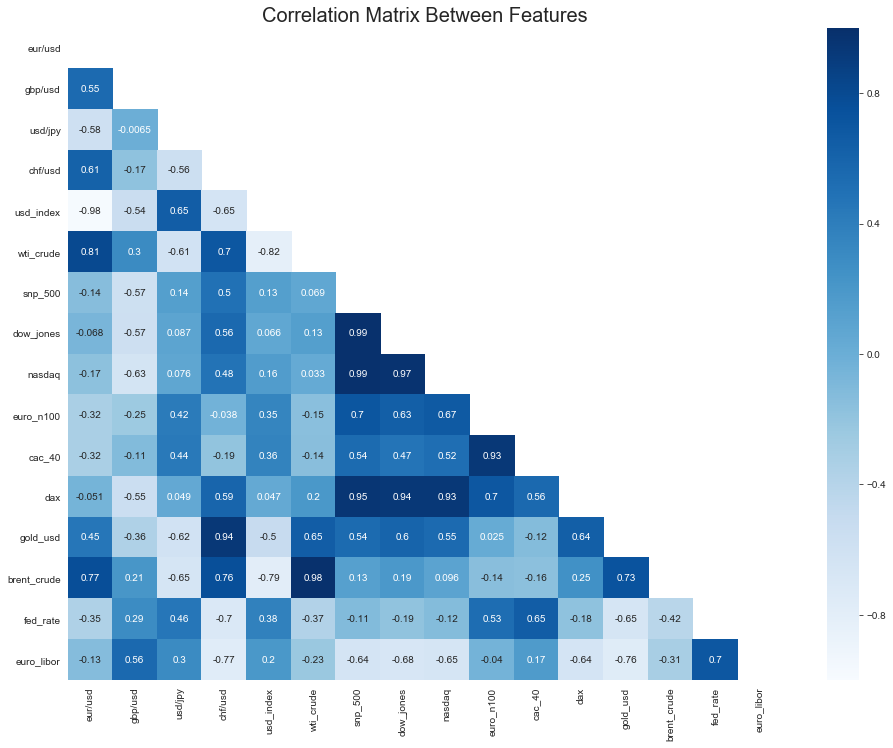

In [172]:
# Setting up the size of the figure
plt.figure(figsize=(16,12)) 
# Insert the title 
plt.title("Correlation Matrix Between Features", fontsize=20) 
corr = final_df.corr()
# Set up mask to be True to hide upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heat_map = sns.heatmap(corr,mask=mask,annot=True,vmin=-1,vmax=1,cmap="Blues")

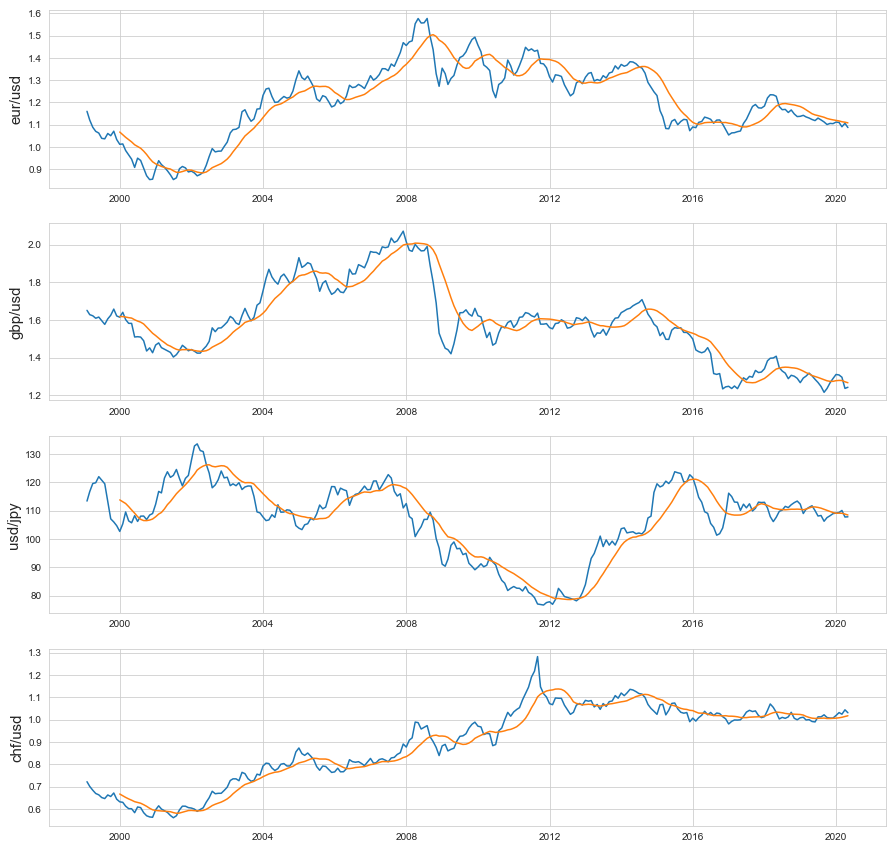

In [183]:
# Overview of the currency pairs performance from 1999 to 2020
# Plot line chart with mean monthly price and a 30 day moving average
ccy_df = final_df[['eur/usd', 'gbp/usd', 'usd/jpy', 'chf/usd']]
ccy_df = ccy_df.resample('M').mean()
fig, axes = plt.subplots(nrows=4, figsize=(15,15))

for i, columns in enumerate(ccy_df.columns):
    axes[i].set_ylabel(columns, fontsize=15)
    axes[i].plot(ccy_df[columns])
    axes[i].plot(ccy_df[columns].rolling(12).mean())

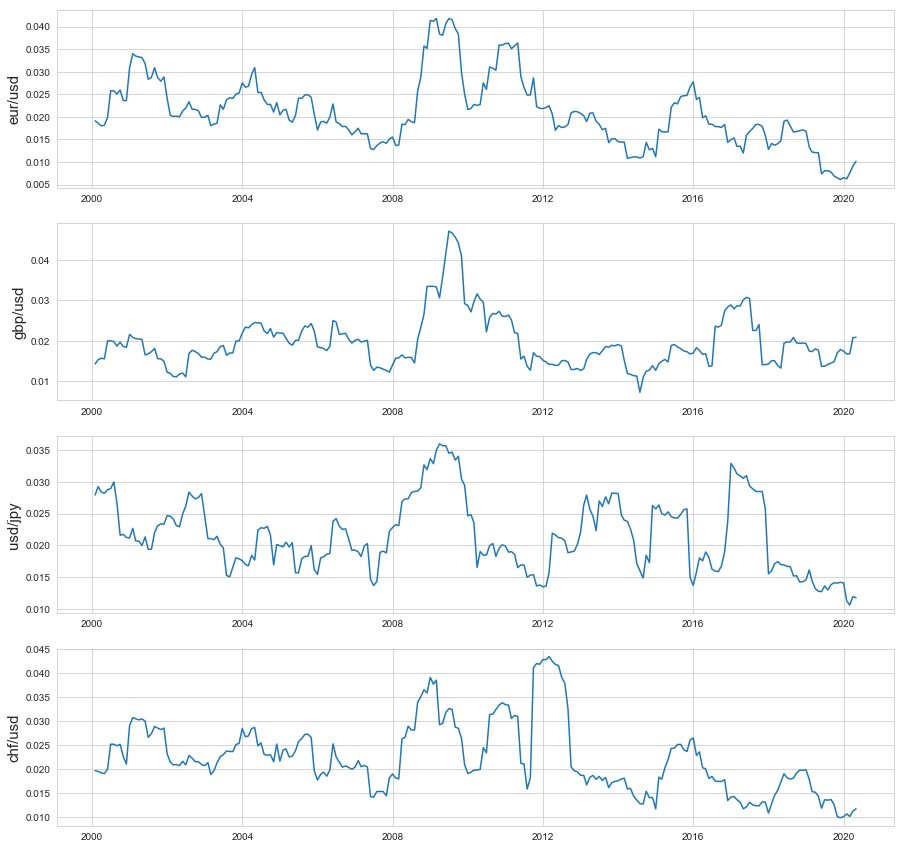

In [185]:
# Looking at the volatility of the monthly price for each currency pair between 1999 and 2020 
fig, axes = plt.subplots(nrows=4, figsize=(15,15))

for i, columns in enumerate(ccy_df.columns):
    axes[i].set_ylabel(columns, fontsize=15)
    axes[i].plot(ccy_df[columns].pct_change().rolling(12).std())

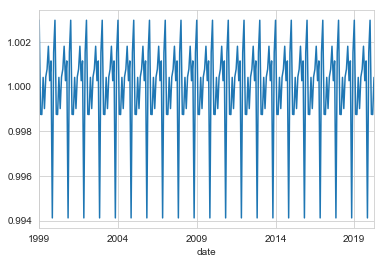

In [203]:
# Identify which component Error/Trend/Seasonality contributes to Eur/Usd behavior
result = seasonal_decompose(ccy_df['eur/usd'], model='mul')
ets_decomposition.seasonal.plot()
pyplot.show()

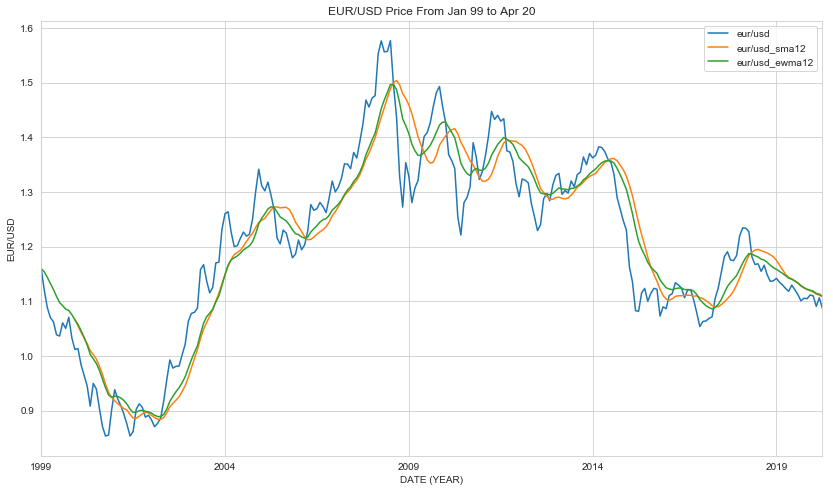

In [99]:
# Looking at EUR/USD trend with SMA and EWMA (Exponentially-Weighted Moving Average)
# The EUR/USD is not a stationary time series
ccy_df['eur/usd_sma12'] = ccy_df['eur/usd'].rolling(window=12).mean()
ccy_df['eur/usd_ewma12'] = ccy_df['eur/usd'].ewm(span=12,adjust=False).mean()

title = 'EUR/USD Price From Jan 99 to Apr 20'
ylabel = 'EUR/USD'
xlabel = 'DATE (YEAR)'
ax = ccy_df[['eur/usd', 'eur/usd_sma12', 'eur/usd_ewma12']].plot(figsize=(14,8), title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel = xlabel, ylabel = ylabel);

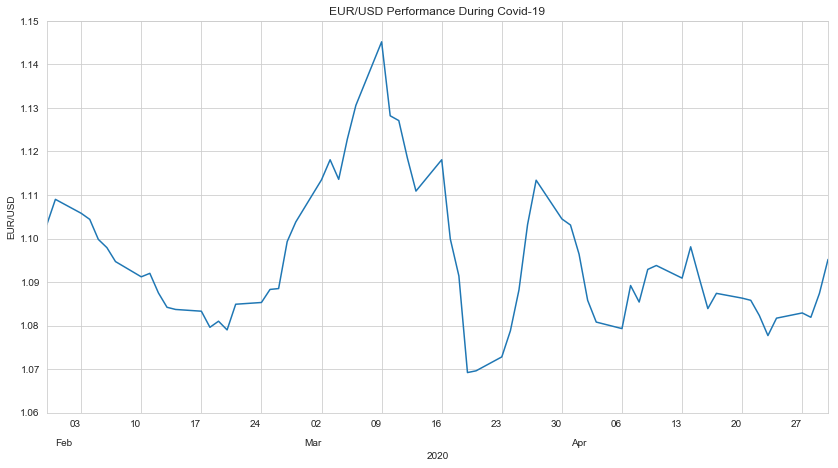

In [119]:
# Analyzing how the EUR/USD has preformed over the last 3 months with Covid-19
title = 'EUR/USD Performance During Covid-19'
ylabel = 'EUR/USD'
xlabel = '2020'
ax = final_df['eur/usd'].plot(figsize=(14,8), xlim=['2020-01-30','2020-04-30'],ylim=[1.06,1.15],rot=0,title=title)
ax.set(xlabel=xlabel, ylabel = ylabel)

ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d'))

ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%b'))

### Preprocess and Modeling

In [190]:
# Set up train and test with month of November's data (train) and 1st week of December data (test)
train = final_df.loc['2019-11-01':'2019-11-29']
test = final_df.loc['2019-12-02':'2019-12-06']

In [193]:
# Scale data using MinMax Scaler
mm = MinMaxScaler()
train_mm = mm.fit_transform(train)
test_mm = mm.transform(test)

In [195]:
length = 1 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(train_mm, train_mm, length=length, batch_size=batch_size)

In [196]:
len(train_mm)

21

In [197]:
len(generator)

20

In [198]:
# What does the first batch look like?
X,y = generator[0]

In [199]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1.         0.93373494 0.         1.         0.00840336 0.28955224
 0.         0.         0.         0.         0.         0.
 1.         0.31920904 0.         0.5        0.74693442]
Predict this y: 
 [[0.7791411  0.57831325 0.32       0.82876712 0.         0.39104478
  0.13116268 0.14232205 0.14681432 0.33872565 0.3518435  0.53357084
  0.90386555 0.44350282 0.         0.5        0.22867012]]


In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [201]:
train_mm.shape

(21, 17)

In [202]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,train_mm.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(train_mm.shape[1]))

model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               47200     
_________________________________________________________________
dense (Dense)                (None, 17)                1717      
Total params: 48,917
Trainable params: 48,917
Non-trainable params: 0
_________________________________________________________________
